In [2]:
from typing import Dict, List, Optional
import matplotlib.pyplot as plt
from hydra import compose, initialize
from hydra.utils import instantiate
import numpy as np
import pytorch_lightning as pl
import torch
from torch import Tensor
import torch.nn.functional as F
from einops import rearrange
from torch.utils.data import DataLoader, Dataset
import galsim
from bliss.catalog import TileCatalog, get_is_on_from_n_sources, FullCatalog
from bliss.datasets.background import ConstantBackground
from bliss.datasets.sdss import convert_flux_to_mag
from bliss.models.galsim_decoder import (
    SingleGalsimGalaxyDecoder,
    SingleGalsimGalaxyPrior,
    UniformGalsimGalaxiesPrior,
)
from bliss.datasets.galsim_galaxies import GalsimBlends
from case_studies.coadds.signal_noise_ratio import snr
from case_studies.coadds.align_single_exposures import align_single_exposures


In [3]:
%load_ext autoreload
%autoreload 2
%aimport
%matplotlib inline

Modules to reload:
all-except-skipped

Modules to skip:



In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, Optional
import galsim
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from torch import Tensor
from einops import rearrange, reduce
from bliss.catalog import FullCatalog
from bliss.catalog import TileCatalog, get_is_on_from_n_sources
from bliss.models.galaxy_net import OneCenteredGalaxyAE
from bliss.encoder import Encoder
from bliss.datasets.background import ConstantBackground
from bliss.datasets.galsim_galaxies import SingleGalsimGalaxies
from bliss.models.decoder import GalaxyTileDecoder
from bliss.datasets.galsim_galaxies import GalsimBlends
from bliss.models.galsim_decoder import (
    SingleGalsimGalaxyPrior,
    UniformGalsimGalaxiesPrior,
    FullCatalogDecoder,
)
from bliss.catalog import FullCatalog, TileCatalog
from bliss.models.decoder import get_mgrid
from bliss.models.galsim_decoder import SingleGalsimGalaxyDecoder, load_psf_from_file
from case_studies.coadds.align_single_exposures import align_single_exposures
from case_studies.coadds.signal_noise_ratio import snr


def _sample_n_sources(max_n_sources) -> int:
    return int(torch.randint(1, max_n_sources + 1, (1,)).int().item())


def _uniform(a, b, n_samples=1) -> Tensor:
    # uses pytorch to return a single float ~ U(a, b)
    return (a - b) * torch.rand(n_samples) + b


def _add_noise_and_background(image: Tensor, background: Tensor) -> Tensor:
    image_with_background = image + background
    noise = image_with_background.sqrt() * torch.randn_like(image_with_background)
    return image_with_background + noise


def linear_coadd(aligned_images, cropped_background, weight):
    assert torch.tensor(aligned_images).shape == torch.tensor(cropped_background).shape

    id = torch.tensor(aligned_images) - cropped_background
    num = torch.sum(id / torch.tensor(aligned_images), dim=0)
    return num / (torch.sum(weight, dim=0))


class CoaddUniformGalsimGalaxiesPrior(UniformGalsimGalaxiesPrior):
    def __init__(
        self,
        single_galaxy_prior: SingleGalsimGalaxyPrior,
        max_n_sources: int,
        max_shift: float,
        num_dithers: int,
    ):
        super().__init__(
            single_galaxy_prior,
            max_n_sources,
            max_shift,
        )

    def sample(self, num_dithers: int) -> Dict[str, Tensor]:
        """Returns a single batch of source parameters."""
        n_sources = _sample_n_sources(self.max_n_sources)

        params = torch.zeros(self.max_n_sources, self.dim_latents)
        params[:n_sources, :] = self.single_galaxy_prior.sample(n_sources)

        locs = torch.zeros(self.max_n_sources, 2)
        locs[:n_sources, 0] = _uniform(-self.max_shift, self.max_shift, n_sources) + 0.5
        locs[:n_sources, 1] = _uniform(-self.max_shift, self.max_shift, n_sources) + 0.5

        # for now, galaxies only
        galaxy_bools = torch.zeros(self.max_n_sources, 1)
        galaxy_bools[:n_sources, :] = 1
        star_bools = torch.zeros(self.max_n_sources, 1)

        dithers = [((-0.5 - 0.5) * torch.rand((2,)) + 0.5).numpy() for x in range(num_dithers)]

        return {
            "n_sources": torch.tensor(n_sources),
            "galaxy_params": params,
            "locs": locs,
            "galaxy_bools": galaxy_bools,
            "star_bools": star_bools,
            "dithers": dithers,
        }


class CoaddSingleGalaxyDecoder(SingleGalsimGalaxyDecoder):
    def __init__(
        self,
        slen: int,
        n_bands: int,
        pixel_scale: float,
        psf_image_file: str,
    ):
        super().__init__(
            slen,
            n_bands,
            pixel_scale,
            psf_image_file,
        )
        assert n_bands == 1, "Only 1 band is supported"
        self.slen = slen
        self.n_bands = 1
        self.pixel_scale = pixel_scale
        self.psf = load_psf_from_file(psf_image_file, self.pixel_scale)

    def render_galaxy(
        self,
        galaxy_params: Tensor,
        psf: galsim.GSObject,
        slen: int,
        offset: Optional[Tensor] = None,
        dithers: Optional[Tensor] = None,
    ) -> Tensor:
        assert offset is None or offset.shape == (2,)
        if isinstance(galaxy_params, Tensor):
            galaxy_params = galaxy_params.cpu().detach()
        total_flux, disk_frac, beta_radians, disk_q, a_d, bulge_q, a_b = galaxy_params
        bulge_frac = 1 - disk_frac

        disk_flux = total_flux * disk_frac
        bulge_flux = total_flux * bulge_frac

        components = []
        if disk_flux > 0:
            b_d = a_d * disk_q
            disk_hlr_arcsecs = np.sqrt(a_d * b_d)
            disk = galsim.Exponential(flux=disk_flux, half_light_radius=disk_hlr_arcsecs).shear(
                q=disk_q,
                beta=beta_radians * galsim.radians,
            )
            components.append(disk)
        if bulge_flux > 0:
            b_b = bulge_q * a_b
            bulge_hlr_arcsecs = np.sqrt(a_b * b_b)
            bulge = galsim.DeVaucouleurs(
                flux=bulge_flux, half_light_radius=bulge_hlr_arcsecs
            ).shear(q=bulge_q, beta=beta_radians * galsim.radians)
            components.append(bulge)
        galaxy = galsim.Add(components)
        gal_conv = galsim.Convolution(galaxy, psf)
        offset = (0, 0) if offset is None else offset
        dithers = (0, 0) if dithers is None else dithers
        shift = torch.add(torch.Tensor(dithers), torch.Tensor(offset))
        shift = shift.reshape(1, 2) if len(shift) == 2 else shift
        images = []
        for i in shift:
            image = gal_conv.drawImage(
                nx=slen, ny=slen, method="auto", scale=self.pixel_scale, offset=i
            )
            image = image.array
            images.append(image)
        return torch.tensor(images[:]).reshape(len(shift), 1, slen, slen)


class FullCatalogDecoder:
    def __init__(
        self,
        single_galaxy_decoder: CoaddSingleGalaxyDecoder,
        slen: int,
        bp: int,
        dithers: Optional[Tensor],
    ) -> None:
        self.single_decoder = single_galaxy_decoder
        self.slen = slen
        self.bp = bp
        self.dithers = dithers
        assert self.slen + 2 * self.bp >= self.single_decoder.slen

    def __call__(self, full_cat: FullCatalog):
        return self.render_catalog(full_cat, self.single_decoder.psf, self.dithers)

    def render_catalog(
        self, full_cat: FullCatalog, psf: galsim.GSObject, dithers: Optional[Tensor]
    ):
        size = self.slen + 2 * self.bp
        full_plocs = full_cat.plocs
        b, max_n_sources, _ = full_plocs.shape
        assert b == 1, "Only one batch supported for now."
        assert self.single_decoder.n_bands == 1, "Only 1 band supported for now"

        image = torch.zeros(len(dithers), 1, size, size)
        image0 = torch.zeros(1, 1, size, size)
        noiseless_centered = torch.zeros(len(dithers), max_n_sources, 1, size, size)
        noiseless_uncentered = torch.zeros(len(dithers), max_n_sources, 1, size, size)

        n_sources = int(full_cat.n_sources[0].item())
        galaxy_params = full_cat["galaxy_params"][0]
        plocs = full_plocs[0]

        for ii in range(n_sources):
            offset_x = plocs[ii][1] + self.bp - size / 2
            offset_y = plocs[ii][0] + self.bp - size / 2
            offset = torch.tensor([offset_x, offset_y])
            centered = self.single_decoder.render_galaxy(
                galaxy_params[ii], psf, size, dithers=dithers
            )
            uncentered = self.single_decoder.render_galaxy(galaxy_params[ii], psf, size, offset)
            uncentered_dithered = self.single_decoder.render_galaxy(
                galaxy_params[ii], psf, size, offset, dithers
            )
            noiseless_centered[:, ii] = centered.reshape(centered.shape[0], 1, size, size)
            noiseless_uncentered[:, ii] = uncentered.reshape(uncentered.shape[0], 1, size, size)
            image0 += uncentered
            image += uncentered_dithered
        return image, noiseless_centered, noiseless_uncentered, image0


class CoaddGalsimBlends(GalsimBlends):
    """Dataset of coadd galsim blends."""

    def __init__(
        self,
        prior: UniformGalsimGalaxiesPrior,
        decoder: FullCatalogDecoder,
        background: ConstantBackground,
        tile_slen: int,
        max_sources_per_tile: int,
        num_workers: int,
        batch_size: int,
        n_batches: int,
        fix_validation_set: bool = False,
        valid_n_batches: Optional[int] = None,
    ):
        super().__init__(
            prior,
            decoder,
            background,
            tile_slen,
            max_sources_per_tile,
            num_workers,
            batch_size,
            n_batches,
            fix_validation_set,
            valid_n_batches,
        )
        self.slen = self.decoder.slen
        self.pixel_scale = self.decoder.single_decoder.pixel_scale

    def _get_images(self, full_cat, dithers):
        size = self.slen + 2 * self.bp  # check bp gets passed through
        (
            noiseless,
            noiseless_centered,
            noiseless_uncentered,
            image0,
        ) = self.decoder.render_catalog(full_cat = full_cat, psf = self.decoder.single_decoder.psf, dithers = dithers)

        # align single exposures
        aligned_images = align_single_exposures(
            image0[:].reshape(size, size), noiseless, size, dithers
        )

        # calculate weights
        weight = 1 / torch.tensor(aligned_images)

        # get background and noisy image.
        background = (
            self.background.sample((1, *aligned_images.reshape(len(dithers), size, size).shape))
            .squeeze(0)
            .reshape(len(dithers), 1, size, size)
        )
        noisy_aligned_image = _add_noise_and_background(aligned_images, background)

        # get snr
        bg = background[:, :, 1 : size - 1, 1 : size - 1]
        img = noisy_aligned_image.reshape(len(dithers), 1, size - 2, size - 2)
        snr_images = snr(img, bg)

        # coadd images
        cropped_background = background.reshape(len(dithers), size, size)[
            :, 1 : size - 1, 1 : size - 1
        ]
        coadded_image = linear_coadd(noisy_aligned_image, cropped_background, weight)

        return (
            noiseless,
            noiseless_centered,
            noiseless_uncentered,
            background,
            snr_images,
            coadded_image,
        )

    def _add_metrics(
        self,
        full_cat: FullCatalog,
        noiseless: Tensor,
        background: Tensor,
        snr_images: Tensor,
        coadded_image: Tensor,
    ):
        full_cat["coadded_images"] = coadded_image
        full_cat["snr_images"] = snr_images
        full_cat["noiseless"] = noiseless
        full_cat["background"] = background

        return full_cat

    def __getitem__(self, idx):
        full_cat = self._sample_full_catalog()
        noiseless, noiseless_centered, noiseless_uncentered, background, snr_images, coadded_image = self._get_images(full_cat)
        full_cat = self._add_metrics(full_cat, noiseless, background, snr_images, coadded_image)
        return {"noiseless": noiseless, "background": background, "snr_images": snr_images, "coadded_image": coadded_image}

In [ ]:
#############################

In [4]:
with initialize(config_path="../sdss_galaxies/config"):
    cfg = compose("config", overrides=[])

In [5]:
prior = instantiate(cfg.datasets.sdss_galaxies.prior)
decoder = instantiate(cfg.datasets.sdss_galaxies.decoder)
background = instantiate(cfg.datasets.galsim_blended_galaxies.background)
tile_slen = 4
max_tile_n_sources = 1
num_workers = 5
n_batches = 1
max_n_sources = 1
max_shift = 0.5
num_dithers = 4
mprior = instantiate(cfg.models.prior)
tile_catalog = mprior.sample_prior(tile_slen=4, batch_size=3, n_tiles_h=2, n_tiles_w=2)
full_catalog = TileCatalog.to_full_params(tile_catalog)

In [6]:
# Test CUGGP
cuggp = CoaddUniformGalsimGalaxiesPrior(prior, max_n_sources, max_shift, num_dithers)

In [8]:
pixel_scale = 0.393
cuggprior = cuggp.sample(num_dithers)  # does not work if we use galsim_blended_galaxies for prior config
n_sources = cuggprior["n_sources"]
galaxy_params = cuggprior["galaxy_params"]
locs = cuggprior["locs"]
galaxy_bools = cuggprior["galaxy_bools"]
star_bools = cuggprior["star_bools"]
dithers = cuggprior["dithers"]
offset = None
psf = decoder.psf

In [11]:
csgd = CoaddSingleGalaxyDecoder(decoder, n_bands=1, pixel_scale=pixel_scale, psf_image_file="./data/sdss/psField-000094-1-0012-PSF-image.npy")
csgd.render_galaxy(
    galaxy_params=galaxy_params[0],
    slen=decoder.slen,
    psf=decoder.psf,
    offset=offset,
    dithers=dithers,
)

/tmp/ipykernel_370409/1262111034.py:154: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  shift = torch.add(torch.Tensor(dithers), torch.Tensor(offset))


tensor([[[[7.0388e-05, 7.1663e-05, 7.2780e-05,  ..., 2.0875e-04,
           2.1204e-04, 2.1567e-04],
          [8.2380e-05, 8.4635e-05, 8.7183e-05,  ..., 2.5205e-04,
           2.5723e-04, 2.6212e-04],
          [9.6487e-05, 9.8549e-05, 1.0046e-04,  ..., 3.0839e-04,
           3.1360e-04, 3.1918e-04],
          ...,
          [3.1087e-04, 3.0561e-04, 3.0070e-04,  ..., 9.8665e-05,
           9.6775e-05, 9.4688e-05],
          [2.5509e-04, 2.5020e-04, 2.4504e-04,  ..., 8.5076e-05,
           8.2625e-05, 8.0505e-05],
          [2.1051e-04, 2.0712e-04, 2.0403e-04,  ..., 7.1629e-05,
           7.0507e-05, 6.9188e-05]]],


        [[[6.8095e-05, 6.9569e-05, 7.0807e-05,  ..., 1.9836e-04,
           2.0137e-04, 2.0459e-04],
          [7.8673e-05, 8.0645e-05, 8.2962e-05,  ..., 2.3748e-04,
           2.4239e-04, 2.4711e-04],
          [9.2999e-05, 9.5185e-05, 9.7118e-05,  ..., 2.9169e-04,
           2.9642e-04, 3.0140e-04],
          ...,
          [3.2920e-04, 3.2320e-04, 3.1758e-04,  ..., 1.02

In [12]:
prior = instantiate(cfg.datasets.galsim_blended_galaxies.prior)
decoder = instantiate(cfg.datasets.galsim_blended_galaxies.decoder)
background = instantiate(cfg.datasets.galsim_blended_galaxies.background)
tile_slen = 4
max_tile_n_sources = 1
num_workers = 5
batch_size = 1000
n_batches = 1
full_catalog = CoaddGalsimBlends(
    prior=prior,
    decoder=decoder,
    background=background,
    tile_slen=tile_slen,
    max_sources_per_tile=max_tile_n_sources,
    num_workers=num_workers,
    batch_size=batch_size,
    n_batches=n_batches,
)._sample_full_catalog()

In [16]:
slen = 40
bp = 24
fcdecoder = FullCatalogDecoder(decoder, slen, bp, dithers)
fcdecoder.render_catalog(
    full_catalog, psf, dithers
)  # Do I need to change the target in config to bliss.case_study.coadd.coadd_decoder?

AttributeError: 'FullCatalogDecoder' object has no attribute 'n_bands'

In [48]:
dithers

[array([ 0.2863866, -0.2431587], dtype=float32),
 array([0.45234668, 0.29335123], dtype=float32),
 array([0.26052737, 0.14739156], dtype=float32),
 array([-0.45585835,  0.38580644], dtype=float32)]

In [61]:
total_flux, disk_frac, beta_radians, disk_q, a_d, bulge_q, a_b = galaxy_params[0]
bulge_frac = 1 - disk_frac

disk_flux = total_flux * disk_frac
bulge_flux = total_flux * bulge_frac

components = []
if disk_flux > 0:
    b_d = a_d * disk_q
    disk_hlr_arcsecs = np.sqrt(a_d * b_d)
    disk = galsim.Exponential(flux=disk_flux, half_light_radius=disk_hlr_arcsecs).shear(
        q=disk_q,
        beta=beta_radians * galsim.radians,
    )
    components.append(disk)
if bulge_flux > 0:
    b_b = bulge_q * a_b
    bulge_hlr_arcsecs = np.sqrt(a_b * b_b)
    bulge = galsim.DeVaucouleurs(flux=bulge_flux, half_light_radius=bulge_hlr_arcsecs).shear(
        q=bulge_q, beta=beta_radians * galsim.radians
    )
    components.append(bulge)
galaxy = galsim.Add(components)
gal_conv = galsim.Convolution(galaxy, psf)
offset = (0, 0) if offset is None else offset
dithers = (0, 0) if dithers is None else dithers
shift = torch.add(torch.Tensor(dithers), torch.Tensor(offset))
shift = shift.reshape(1, 2) if len(shift) == 2 else shift
images = []
for i in shift:
    image = gal_conv.drawImage(nx=slen, ny=slen, method="auto", scale=pixel_scale, offset=i)
    image = image.array
    images.append(image)
torch.tensor(images[:]).reshape(len(shift), 1, slen, slen)

tensor([[[[ 1.1793,  1.6958,  2.4634,  3.4592,  4.4005,  4.8759,  4.7420,
            4.2210,  3.5967],
          [ 1.8785,  2.9511,  4.7746,  7.2810,  9.5057, 10.1503,  8.9974,
            7.0495,  5.2763],
          [ 2.9133,  4.9548,  8.6741, 13.8458, 18.1251, 18.6036, 15.1922,
           10.5678,  6.9345],
          [ 4.1362,  7.2620, 13.0021, 20.8280, 26.8450, 26.6023, 20.4743,
           13.0587,  7.7308],
          [ 5.0832,  8.6812, 15.0338, 23.3245, 29.1798, 28.0214, 20.7537,
           12.5972,  7.0464],
          [ 5.2786,  8.3288, 13.2848, 19.3080, 23.0901, 21.5138, 15.6202,
            9.3795,  5.2418],
          [ 4.6715,  6.5889,  9.3128, 12.2618, 13.7591, 12.4379,  9.0418,
            5.6158,  3.3293],
          [ 3.6297,  4.5435,  5.6024,  6.5312,  6.7681,  5.9558,  4.4552,
            2.9956,  1.9670],
          [ 2.5708,  2.9065,  3.1882,  3.3267,  3.2029,  2.7798,  2.1867,
            1.6163,  1.1699]]],


        [[[ 0.8828,  1.2061,  1.6308,  2.1284,  2.5862,  2.8

In [17]:
size = decoder.slen + 2 * bp
full_plocs = full_catalog.plocs
b, max_n_sources, _ = full_plocs.shape

image = torch.zeros(len(dithers), 1, size, size)
noiseless_centered = torch.zeros(max_n_sources, len(dithers), size, size)
noiseless_uncentered = torch.zeros(max_n_sources, len(dithers), size, size)

n_sources = int(full_catalog.n_sources[0].item())
galaxy_params = full_catalog["galaxy_params"][0]
plocs = full_plocs[0]

for ii in range(n_sources):
    offset_x = plocs[ii][1] + bp - size / 2
    offset_y = plocs[ii][0] + bp - size / 2
    offset = torch.tensor([offset_x, offset_y])
    centered = csgd.render_galaxy(galaxy_params[ii], psf, size, dithers=dithers)
    uncentered = csgd.render_galaxy(galaxy_params[ii], psf, size, offset, dithers)
    noiseless_centered[ii] = centered.reshape(centered.shape[0], size, size)
    noiseless_uncentered[ii] = uncentered.reshape(uncentered.shape[0], size, size)
    image += uncentered

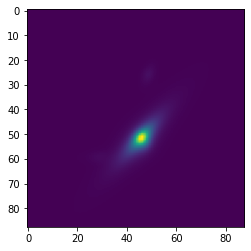

In [20]:
plt.imshow(image[2].reshape(image[2].shape[1], image[2].shape[2]).numpy())

In [66]:
centered.reshape(centered.shape[0], size, size).shape

torch.Size([4, 88, 88])

In [29]:
noiseless_uncentered.shape

torch.Size([6, 4, 88, 88])

In [32]:
noiseless_centered.shape

torch.Size([4, 6, 1, 88, 88])

In [21]:
image = torch.zeros(len(dithers), 1, size, size)
image0 = torch.zeros(1, 1, size, size)
noiseless_centered = torch.zeros(len(dithers), max_n_sources, 1, size, size)
noiseless_uncentered = torch.zeros(len(dithers), max_n_sources, 1, size, size)

n_sources = int(full_catalog.n_sources[0].item())
galaxy_params = full_catalog["galaxy_params"][0]
plocs = full_plocs[0]

for ii in range(n_sources):
    offset_x = plocs[ii][1] + bp - size / 2
    offset_y = plocs[ii][0] + bp - size / 2
    offset = torch.tensor([offset_x, offset_y])
    centered = csgd.render_galaxy(galaxy_params[ii], psf, size, dithers=dithers)
    uncentered = csgd.render_galaxy(galaxy_params[ii], psf, size, offset)
    uncentered_dithered = csgd.render_galaxy(galaxy_params[ii], psf, size, offset, dithers)
    noiseless_centered[:, ii] = centered.reshape(centered.shape[0], 1, size, size)
    noiseless_uncentered[:, ii] = uncentered.reshape(uncentered.shape[0], 1, size, size)
    image0 += uncentered
    image += uncentered_dithered

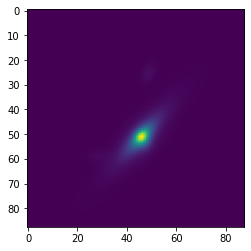

In [22]:
plt.imshow(image0[:].reshape(image0[:].shape[2], image0[:].shape[3]).numpy())

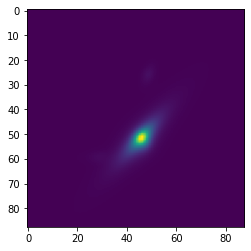

In [23]:
plt.imshow(image[2].reshape(image[2].shape[1], image[2].shape[2]).numpy())

In [24]:
# check noise and dither independence
background = instantiate(cfg.datasets.sdss_galaxies.background)
background = (
    background.sample((1, *image.reshape(len(dithers), size, size).shape))
    .squeeze(0)
    .reshape(1, len(dithers), size, size)
)
_add_noise_and_background(image, background)

image_with_background = image + background
noise = image_with_background.sqrt() * torch.randn_like(
    image_with_background
)  # randomized by value of Tensor
noisy_image = image_with_background + noise

In [31]:
instantiate(cfg.datasets.sdss_galaxies.background).sample((1, *image.reshape(len(dithers), size, size).shape)).squeeze(0).reshape(len(dithers), 1, size, size).shape

torch.Size([4, 1, 88, 88])

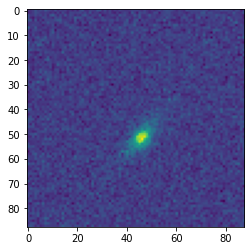

In [25]:
plt.imshow(noisy_image[2].reshape(noisy_image[2].shape[1], noisy_image[2].shape[2]).numpy())

In [33]:
i0 = galsim.Image(np.array(image0[:].reshape(88, 88)), wcs=galsim.PixelScale(pixel_scale))
i1 = galsim.Image(np.array(image[:][0].reshape(88, 88)))

In [34]:
from bliss.models.decoder import get_mgrid


def align_single_exposures(img0, img1, slen, dithers):
    img0 = galsim.Image(np.array(img0), wcs=galsim.PixelScale(scale))
    wcs0 = img0.wcs
    images = img1

    sgrid = (get_mgrid(slen) - (-1)) / 2 * (slen)
    sgrid = sgrid.reshape(slen**2, 2)
    grid_x = wcs0.xyTouv(sgrid[:, 0], sgrid[:, 1])[0]
    grid_y = wcs0.xyTouv(sgrid[:, 0], sgrid[:, 1])[1]

    grid = torch.empty(size=(0, 2))
    for i in dithers:
        wcs1 = galsim.OffsetWCS(scale=scale, origin=galsim.PositionD(i))
        x, y = wcs1.uvToxy(grid_x, grid_y)
        x_grid = (x / slen) * 2 + (-1)
        y_grid = (y / slen) * 2 + (-1)
        grid = torch.cat(
            [grid, torch.stack((torch.tensor(x_grid), torch.tensor(y_grid)), -1)], dim=0
        )

    iplots = []
    input = torch.tensor(images[:]).reshape(len(dithers), 1, slen, slen).float()
    grids = grid.reshape(len(dithers), 1, slen * slen, 2).float()
    iplots.append(F.grid_sample(input, grids, align_corners=False))

    # reshape and crop 1 pixel on each side
    iplots = torch.tensor(iplots[:][0]).reshape(len(dithers), slen, slen)
    iplots_cropped = iplots[:, 1 : slen - 1, 1 : slen - 1]
    return iplots_cropped

In [35]:
image0[:].reshape(size, size)

tensor([[0.0012, 0.0013, 0.0013,  ..., 0.3699, 0.3773, 0.3812],
        [0.0013, 0.0013, 0.0014,  ..., 0.4010, 0.4060, 0.4070],
        [0.0013, 0.0014, 0.0014,  ..., 0.4326, 0.4344, 0.4318],
        ...,
        [0.2243, 0.2566, 0.2938,  ..., 0.0025, 0.0023, 0.0022],
        [0.2419, 0.2762, 0.3154,  ..., 0.0023, 0.0022, 0.0021],
        [0.2598, 0.2959, 0.3368,  ..., 0.0022, 0.0021, 0.0020]])

In [39]:
# Add alignment and coadding
img0 = image0[:].reshape(size, size)
imgs = noisy_image
aligned_images = align_single_exposures(img0, imgs, size, dithers)

/home/wmallory/bliss/case_studies/coadds/align_single_exposures.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [grid, torch.stack((torch.tensor(x_grid), torch.tensor(y_grid)), -1)], dim=0
/home/wmallory/bliss/case_studies/coadds/align_single_exposures.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(images[:]).reshape(len(dithers), 1, slen, slen).float()
/home/wmallory/bliss/case_studies/coadds/align_single_exposures.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interped_images = torch.tensor(interped

In [40]:
aligned_images.shape

torch.Size([4, 86, 86])

In [76]:
# add snr
bg = background[:, :, 1 : size - 1, 1 : size - 1]
img = aligned_images.reshape(len(dithers), 1, size - 2, size - 2)
img - bg
torch.sqrt(torch.sum((img - bg) ** 2 / (img - bg + bg), dim=(3, 2, 1)))
snr(img, bg)

tensor([136.0448, 138.6431, 136.8939, 142.1997])

In [80]:
# Coadd using direct coadd: linear combination
# Direct coadd, where weights are proportional to inverse variance
bd = background.reshape(len(dithers), size, size)[
    :, 1 : size - 1, 1 : size - 1
]  # background cropped
id = torch.tensor(aligned_images) - bd  # aligned images without background
weight = 1 / torch.tensor(aligned_images)
num = torch.sum(id / torch.tensor(aligned_images), dim=0)
coadded = num / (torch.sum(weight, dim=0))


def linear_coadd(aligned_images, cropped_background):
    assert torch.tensor(aligned_images).shape == torch.tensor(cropped_background).shape

    id = torch.tensor(aligned_images) - cropped_background
    weight = 1 / torch.tensor(aligned_images)
    num = torch.sum(id / torch.tensor(aligned_images), dim=0)
    return num / (torch.sum(weight, dim=0))

/tmp/ipykernel_3544359/3013547580.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  id = torch.tensor(aligned_images) - bd # aligned images without background
/tmp/ipykernel_3544359/3013547580.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weight = 1 / torch.tensor(aligned_images)
/tmp/ipykernel_3544359/3013547580.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  num = torch.sum(id / torch.tensor(aligned_images), dim = 0)


In [78]:
linear_coadd(aligned_images, bd)

/tmp/ipykernel_3544359/3013547580.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  assert torch.tensor(aligned_images).shape == torch.tensor(cropped_background).shape
/tmp/ipykernel_3544359/3013547580.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  id = torch.tensor(aligned_images) - cropped_background
/tmp/ipykernel_3544359/3013547580.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weight = 1 / torch.tensor(aligned_images)
/tmp/ipykernel_3544359/3013547580.py:14: UserWarning: To copy construct from a tensor, it is recommend

tensor([[ -9.5924,  -1.8391,  14.0782,  ...,   8.2881, -12.3868,  -7.4500],
        [  4.4901,   4.2201,   0.3503,  ...,  -2.6362,   6.4967, -16.1851],
        [  7.1576,  -1.5991,   1.3860,  ...,  -8.0366,   6.5830, -11.0430],
        ...,
        [-11.5103,  -0.8608,   3.2939,  ...,  -0.1660,  -5.4660, -13.9961],
        [ 16.2789,  19.9595,   4.8391,  ...,   8.0546,   1.4545,  -7.9584],
        [ 18.7504,  14.9841,   8.1432,  ...,   5.8145,   2.0300,  -2.4380]])

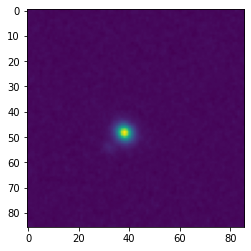

In [79]:
plt.imshow(coadded.numpy())

In [4]:
# check test align
with initialize(config_path="../sdss_galaxies/config"):
    cfg = compose("config", overrides=[])

In [5]:
# create dithers
n = 3
dithers = [((-0.5 - 0.5) * torch.rand((2,)) + 0.5).numpy() for x in range(n)]

In [6]:
decoder = instantiate(cfg.datasets.sdss_galaxies.decoder)
psf = decoder.psf
prior = instantiate(cfg.datasets.galsim_blended_galaxies.prior)
decoder = instantiate(cfg.datasets.galsim_blended_galaxies.decoder)
background = instantiate(cfg.datasets.galsim_blended_galaxies.background)
tile_slen = 4
max_tile_n_sources = 1
num_workers = 5
batch_size = 1000
n_batches = 1
full_catalog = GalsimBlends(
    prior=prior,
    decoder=decoder,
    background=background,
    tile_slen=tile_slen,
    max_sources_per_tile=max_tile_n_sources,
    num_workers=num_workers,
    batch_size=batch_size,
    n_batches=n_batches,
)._sample_full_catalog()

In [7]:
def render_galaxy(
    self,
    galaxy_params: Tensor,
    psf: galsim.GSObject,
    slen: int,
    offset: Optional[Tensor] = None,
    dithers: Optional[Tensor] = None,
) -> Tensor:
    assert offset is None or offset.shape == (2,)
    if isinstance(galaxy_params, Tensor):
        galaxy_params = galaxy_params.cpu().detach()
    total_flux, disk_frac, beta_radians, disk_q, a_d, bulge_q, a_b = galaxy_params
    bulge_frac = 1 - disk_frac

    disk_flux = total_flux * disk_frac
    bulge_flux = total_flux * bulge_frac

    components = []
    if disk_flux > 0:
        b_d = a_d * disk_q
        disk_hlr_arcsecs = np.sqrt(a_d * b_d)
        disk = galsim.Exponential(flux=disk_flux, half_light_radius=disk_hlr_arcsecs).shear(
            q=disk_q,
            beta=beta_radians * galsim.radians,
        )
        components.append(disk)
    if bulge_flux > 0:
        b_b = bulge_q * a_b
        bulge_hlr_arcsecs = np.sqrt(a_b * b_b)
        bulge = galsim.DeVaucouleurs(flux=bulge_flux, half_light_radius=bulge_hlr_arcsecs).shear(
            q=bulge_q, beta=beta_radians * galsim.radians
        )
        components.append(bulge)
    galaxy = galsim.Add(components)
    gal_conv = galsim.Convolution(galaxy, psf)
    offset = (0, 0) if offset is None else offset
    dithers = (0, 0) if dithers is None else dithers
    shift = torch.add(torch.Tensor(dithers), torch.Tensor(offset))
    shift = shift.reshape(1, 2) if len(shift) == 2 else shift
    images = []
    for i in shift:
        image = gal_conv.drawImage(
            nx=slen, ny=slen, method="auto", scale=self.pixel_scale, offset=i
        )
        image = image.array
        images.append(image)
    return torch.tensor(images[:]).reshape(len(shift), 1, slen, slen)

In [8]:
size = decoder.slen + 2 * decoder.bp
full_plocs = full_catalog.plocs
b, max_n_sources, _ = full_plocs.shape

image = torch.zeros(len(dithers), 1, size, size)
image0 = torch.zeros(1, 1, size, size)
noiseless_centered = torch.zeros(len(dithers), max_n_sources, 1, size, size)
noiseless_uncentered = torch.zeros(len(dithers), max_n_sources, 1, size, size)

n_sources = int(full_catalog.n_sources[0].item())
galaxy_params = full_catalog["galaxy_params"][0]
plocs = full_plocs[0]

offset_x = plocs[0][1] + decoder.bp - size / 2
offset_y = plocs[0][0] + decoder.bp - size / 2
offset = torch.tensor([offset_x, offset_y])
decoder = instantiate(cfg.datasets.sdss_galaxies.decoder)
uncentered = render_galaxy(decoder, galaxy_params[0], psf, size, offset)
uncentered_dithered = render_galaxy(decoder, galaxy_params[0], psf, size, offset, dithers)

/tmp/ipykernel_511269/3154264753.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  return torch.tensor(images[:]).reshape(len(shift), 1, slen, slen)


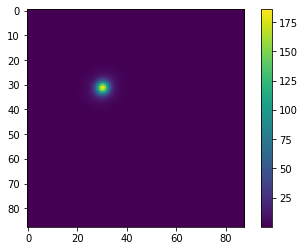

In [9]:
plt.figure()
plt.imshow(uncentered.reshape(size, size))
plt.colorbar()

In [10]:
# now the data is like the output from render_catalog with only one source
img0 = uncentered.reshape(size, size)
images = uncentered_dithered

In [11]:
aligned_images = align_single_exposures(img0, images, size, dithers)
aligned_images.shape  # the output should be cropped

/home/wmallory/bliss/case_studies/coadds/align_single_exposures.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [grid, torch.stack((torch.tensor(x_grid), torch.tensor(y_grid)), -1)], dim=0
/home/wmallory/bliss/case_studies/coadds/align_single_exposures.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(images[:]).reshape(len(dithers), 1, slen, slen).float()
/home/wmallory/bliss/case_studies/coadds/align_single_exposures.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interped_images = torch.tensor(interped

torch.Size([3, 86, 86])

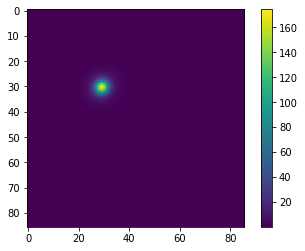

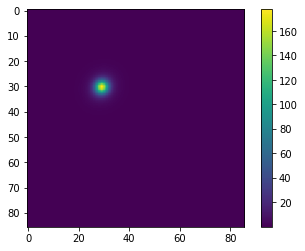

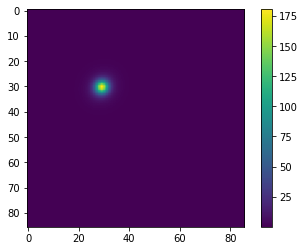

In [12]:
# still hard to tell the dithers
for i in range(len(dithers)):
    plt.figure()
    plt.imshow(aligned_images[i])
    plt.colorbar()

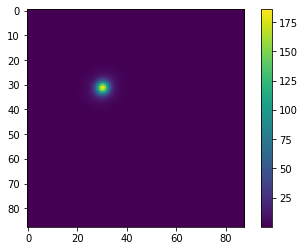

In [15]:
plt.figure()
plt.imshow(img0)
plt.colorbar()

In [ ]:
#### Tests